# Machine Learning Foundation

## Course 3, Part a: Logistic Regression LAB


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration 
- Triaxial Angular velocity from the gyroscope 
- A 561-feature vector with time and frequency domain variables 
- The activity label 

More information about the features are available on the website linked above.


In [2]:
!pip install seaborn  
!pip install pandas
!pip install numpy
!pip install  matplotlib
!pip install scikit-learn

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
import seaborn as sns, pandas as pd, numpy as np

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts.
* Determine if the floating point values need to be scaled.
* Determine the breakdown of each activity.
* Encode the activity label as an integer.


In [5]:
### BEGIN SOLUTION
data = pd.read_csv("../data/human_activity_recognition.csv")

The data columns are all floats except for the activity label.


In [6]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [7]:
data.shape

(10299, 562)

In [8]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).


In [9]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [10]:
data.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

Examine the breakdown of activities; they are relatively balanced.


In [11]:
object_columns = data.select_dtypes(include=['object'])
object_columns.head()

,Activity
0,STANDING
1,STANDING
2,STANDING
3,STANDING
4,STANDING


In [12]:
data.Activity.value_counts() #DATA is Balanced....think about ROC

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)
### END SOLUTION

6291    1
8435    1
4876    5
1707    3
2193    5
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values.
* Identify those that are most correlated (either positively or negatively).


In [15]:
### BEGIN SOLUTION
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()



# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values) #Returns the indices for the lower triangle of the matrix

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs() 

A histogram of the absolute value correlations.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

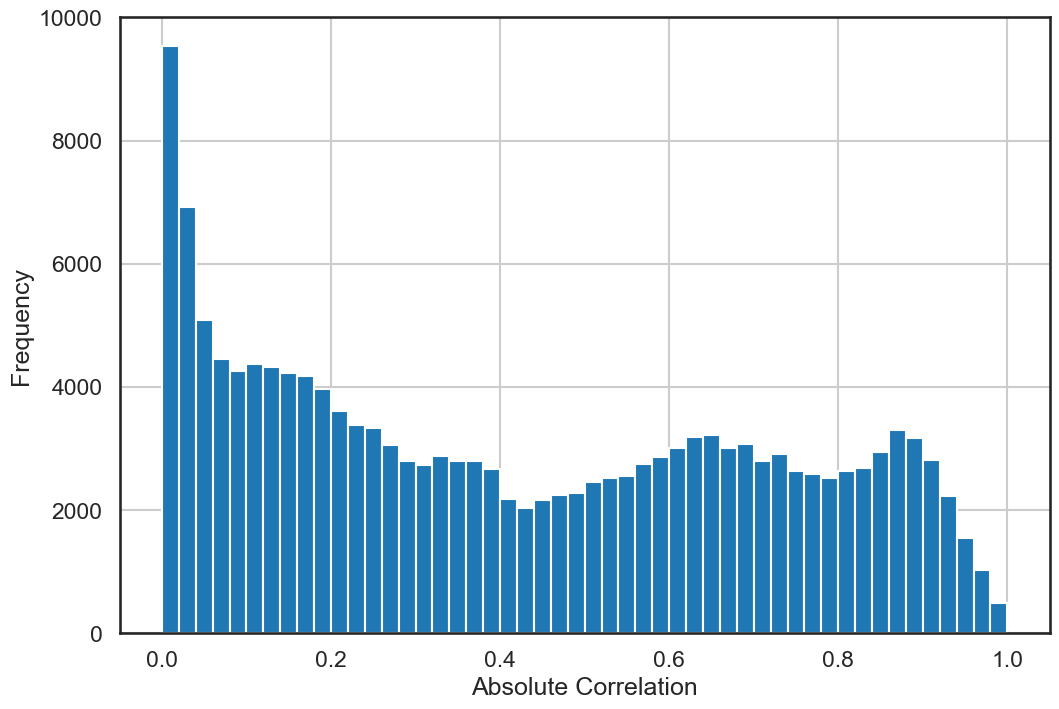

In [17]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [18]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')
### END SOLUTION

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.


In [19]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [20]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [21]:
y_test.value_counts(normalize=True)
### END SOLUTION

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.


In [22]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [23]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [24]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)
### END SOLUTION

## Question 5

* Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 


In [25]:
### BEGIN SOLUTION
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
419 -0.001539  0.197548  0.234874  0.237327  0.122820  0.064808 -0.075888   
376  0.050734 -0.782137  0.887713  0.179406  0.396444 -0.159489 -0.036854   
33   0.031591 -0.449316  0.116962 -0.130071 -0.132161 -0.596385  0.193935   
46   0.175420  0.201696  0.449560  0.215527 -0.405236 -0.086071  0.136558   
58   0.786084  0.092813 -0.867347  0.538181 -0.001662 -0.528964  0.995160   
428 -0.041810 -0.086041 -0.051703  0.093831 -0.450421  0.491318 -0.005205   
255 -0.008875 -0.031974  0.291597 -0.093509  0.174068 -0.343126 -0.048182   
237  0.106739  0.215386 -0.092231  0.296662 -0.079700 -0.214612  0.293368   
532  0.040457  0.831840 -0.514372 -0.213895  0.512250 -0.044362  0.000000   
336  0.012760  0.211213  0.169117 -0.123425  0.175218  0.169581  0.000000   

                                                             l2            \
            1         2         3         4         5         0         1   
419  0.229901  0.276393  0.192102  0.102104  0.110262 -0.023849  0.259981   
376 -2.105056  2.762218  0.115506  0.310537 -0.133943  0.094160 -1.454859   
33  -1.162438  0.050232  0.000000  0.000000 -2.578056  0.020095 -0.695403   
46   0.022525  1.023407  0.210635 -0.243832  0.000000  0.291733  0.286865   
58   1.997588  0.000000  0.308036  0.103748 -0.395917  1.391091  0.572631   
428  0.000000  0.000000  0.516673 -0.478985  0.901385 -0.058257 -0.164143   
255  0.000000  0.024537  0.000000  0.029491 -0.745649 -0.023212 -0.035573   
237  0.000000  0.077888  0.000000  0.000000 -0.121935  0.190447  0.341532   
532  2.083295 -0.219047 -0.030985  0.572723  0.166703  0.064596  1.294739   
336  0.000000  0.000000 -0.005699  0.147899  0.199749  0.002672  0.291816   

                                             
            2         3         4         5  
419  0.292961  0.700178  0.211627  0.202175  
376  1.623085  0.404886  1.128565 -0.486542  
33   0.254702 -0.195702 -0.191306 -1.164242  
46   0.718747  0.675225 -0.925238 -0.529313  
58  -0.646396  1.758338  0.052323 -1.185561  
428 -0.026262  0.185414 -0.915935  0.945855  
255  0.386937 -0.236747  0.435321 -1.229934  
237 -0.118376  0.408301 -0.275833 -0.448438  
532 -0.978686 -0.611744  1.316323  0.051615  
336  0.179421 -0.343695  0.220399  0.323213

Prepare six separate plots for each of the multi-class coefficients.


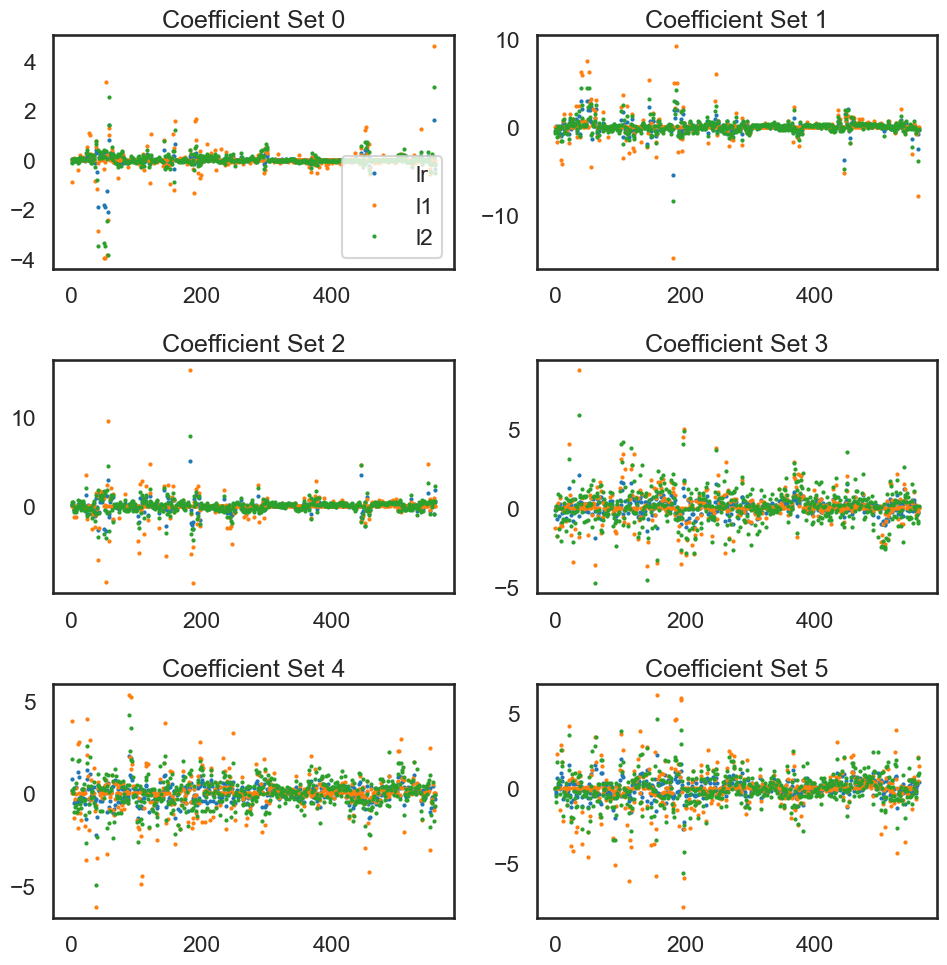

In [26]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()
### END SOLUTION

## Question 6

* Predict and store the class for each model.
* Store the probability for the predicted class for each model. 


In [27]:
### BEGIN SOLUTION
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [28]:
y_prob.head()
### END SOLUTION

,lr,l1,l2
0,0.998939,0.998874,0.999733
1,0.988165,0.999554,0.999477
2,0.987592,0.995700,0.997570
3,0.981381,0.999190,0.994276
4,0.998277,0.999922,0.999615


## Question 7

For each model, calculate the following error metrics: 

* Accuracy
* Precision
* Recall
* F-score
* Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.


In [29]:
### BEGIN SOLUTION
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [33]:
metrics
### END SOLUTION

,lr,l1,l2
precision,0.984144,0.984153,0.983825
recall,0.984142,0.984142,0.983819
fscore,0.984143,0.984140,0.983818
accuracy,0.984142,0.984142,0.983819
auc,0.990384,0.990342,0.990162


## Question 8

* Display or plot the confusion matrix for each model.


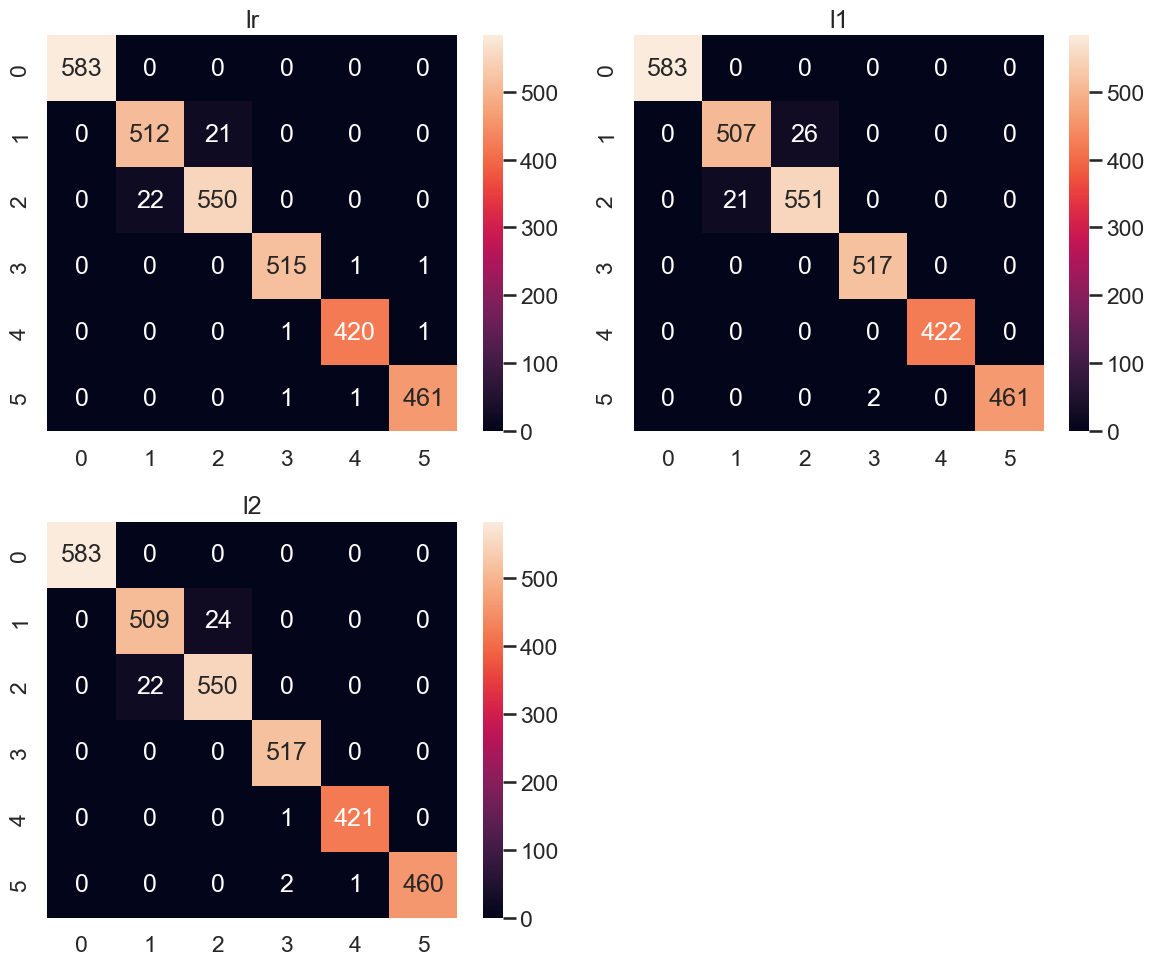

In [31]:
### BEGIN SOLUTION
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation
